In [35]:
import subprocess as sp
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from osgeo import gdal, ogr
from pandas.tseries import offsets
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def listall(RootFolder, varname='',extension='.png'):
    lists = [os.path.join(root, name)
             for root, dirs, files in os.walk(RootFolder)
             for name in files
             if varname in name
             if name.endswith(extension)]
    return lists

# see note below
def youCanQuoteMe(item):
    return "\"" + item + "\""   

In [7]:
files = listall(r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_myd13a2', extension='.tif')

In [10]:
index = []
for i in files:
    # get date
    year = int(i[-12:-8])
    doy = int(i[-7:-4])
    date = datetime(year, 1, 1) + timedelta(doy - 1)
    date = np.datetime64(date)
    date = pd.Timestamp(np.datetime_as_string(date))
    index.append(date)
index = np.array(index)
df = pd.DataFrame(index=index)

In [12]:
month = df.index.map(lambda x: x.month)
year = df.index.map(lambda x: x.year)
day = df.index.map(lambda x: x.day)
doy =  df.index.map(lambda x: x.dayofyear)
# select only dates between certain month
df_sel = (df[(month >= 1) & (month <=6)] + 
          df[(month >= 10) & (month <=12)]).sort_index()
index_sel = pd.Series(np.in1d(df.index,df_sel.index))

In [60]:
# VHI VHI START
# get index from tif files
files = listall(r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_myd13a2', extension='.tif')
index = []
for i in files:
    # get date
    year = int(i[-12:-8])
    doy = int(i[-7:-4])
    date = datetime(year, 1, 1) + timedelta(doy - 1)
    date = np.datetime64(date)
    date = pd.Timestamp(np.datetime_as_string(date))
    index.append(date)
index = np.array(index) 

# create empty DataFrame
df = pd.DataFrame(index=index, columns=['NDVI_mean'])
#df_shp = pd.DataFrame(index=index, columns=columns)

In [61]:
#array = np.zeros((len(files),15,15))
for idx, i in enumerate(files):
    # load raster GeoTransform, RasterBand    
    try:
        src_ds = gdal.Open(i) 
        gt = src_ds.GetGeoTransform()
        rb = src_ds.GetRasterBand(1)

        # get date
        year = int(i[-12:-8])
        doy = int(i[-7:-4])
        date = datetime(year, 1, 1) + timedelta(doy - 1)
        date = np.datetime64(date)
        date = pd.Timestamp(np.datetime_as_string(date))
        #print date
    except Exception, e:
        print e, i
        continue
    try:
        # get mean of nine pixels surround station ID
        array_ID_nine = rb.ReadAsArray()
        #array_ID_nine = np.ma.masked_equal(array_ID_nine, 0)
        stationID_mean = np.ma.mean(array_ID_nine)
        df.ix[date]['NDVI_mean'] = stationID_mean
        #array[idx] = array_ID_nine
    except Exception, e:
        print e, i
        continue

In [62]:
s0102 = df.loc['20011009':'20020610']
s0708 = df.loc['20071009':'20080610']
s1011 = df.loc['20101009':'20110610']
s1112 = df.loc['20111009':'20120610']

In [28]:
# u, indices = np.unique(s0102.index.month, return_index=True)
# np.array([1,  24,  54, 85, 116, 144, 175, 205, 236]) - 1

array([  0,  23,  53,  84, 115, 143, 174, 204, 235])

In [33]:
sos0102 = (pd.Timestamp('2001-10-30') + offsets.DateOffset(84)).dayofyear
eos0102 = (pd.Timestamp('2005-05-30') + offsets.DateOffset(84)).dayofyear

sos0708 = (pd.Timestamp('2007-10-20') + offsets.DateOffset(84)).dayofyear
eos0708 = (pd.Timestamp('2008-06-02') + offsets.DateOffset(84)).dayofyear

sos1011 = (pd.Timestamp('2010-10-19') + offsets.DateOffset(84)).dayofyear
eos1011 = (pd.Timestamp('2011-05-30') + offsets.DateOffset(84)).dayofyear

sos1112 = (pd.Timestamp('2011-10-16') + offsets.DateOffset(84)).dayofyear
eos1112 = (pd.Timestamp('2012-06-02') + offsets.DateOffset(84)).dayofyear

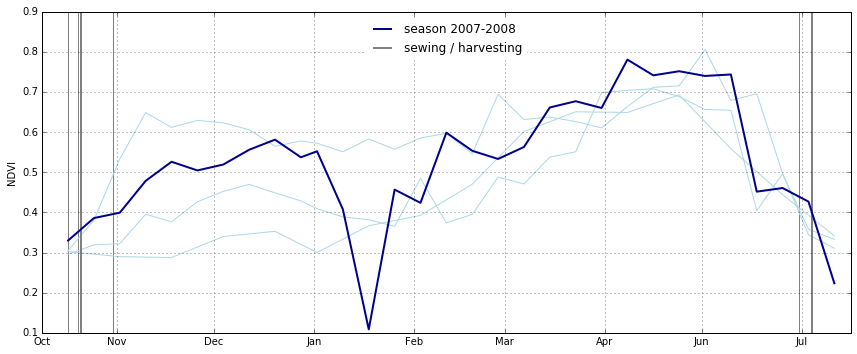

In [64]:
fig,ax = plt.subplots(figsize=(12,5))
ax.axvline(sos0102, color='gray')
ax.axvline(sos0708, color='gray')
ax.axvline(sos1011, color='gray')
ax.axvline(sos1112, color='gray')
ax.axvline(eos0102, color='gray')
ax.axvline(eos0708, color='gray')
ax.axvline(eos1011, color='gray')
ax.axvline(eos1112, color='gray')

ax.plot((s0102.index + offsets.DateOffset(84)).dayofyear, s0102.values/10000., 
         color='lightblue', label='01-02')
plot1011, = ax.plot((s0708.index + offsets.DateOffset(84)).dayofyear, s0708.values/10000., 
         color='darkblue', label='07-08', lw=2, zorder=40)
ax.plot((s1011.index + offsets.DateOffset(84)).dayofyear, s1011.values/10000., 
                   color='lightblue', label='10-11')
ax.plot((s1112.index + offsets.DateOffset(84)).dayofyear, s1112.values/10000., 
         color='lightblue', label='11-12')
#plt.legend()

ax.set_xticks(np.array([  0,  23,  53,  84, 115, 143, 174, 204, 235]))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','Jun','Jul'])
ax.set_ylabel('NDVI')
ax.set_ylim(0.1,0.9)

plt_sos1011 = ax.axvline(sos0708, color='gray',lw=2)
plt_eos1011 = ax.axvline(eos0708, color='gray',lw=2)
plt.grid()
plt.tight_layout()
leg = plt.legend([plot1011,plt_sos1011],['season 2007-2008',
                                                    'sewing / harvesting'], loc=9)
leg.get_frame().set_linewidth(0.0)
plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png//seasons_sel_yongqiao_RAW_NDVI_v1.png',dpi=600)
plt.show()

In [50]:
# VHI VHI START
# get index from tif files
files = listall(r'D:\Data\NDAI_VHI_GROUNDTRUTH\tif\mod13a2_myd13a2_RECON\recon-mcd13a2', extension='.tif')
index = []
for i in files:
    # get date
    year = int(i[-23:-19])
    doy = int(i[-7:-4])
    date = datetime(year, 1, 1) + timedelta(doy - 1)
    date = np.datetime64(date)
    date = pd.Timestamp(np.datetime_as_string(date))
    index.append(date)
index = np.array(index) 

# create empty DataFrame
df = pd.DataFrame(index=index, columns=['NDVI_mean'])
#df_shp = pd.DataFrame(index=index, columns=columns)

In [51]:
#array = np.zeros((len(files),15,15))
for idx, i in enumerate(files):
    # load raster GeoTransform, RasterBand    
    try:
        src_ds = gdal.Open(i) 
        gt = src_ds.GetGeoTransform()
        rb = src_ds.GetRasterBand(1)

        # get date
        year = int(i[-23:-19])
        doy = int(i[-7:-4])
        date = datetime(year, 1, 1) + timedelta(doy - 1)
        date = np.datetime64(date)
        date = pd.Timestamp(np.datetime_as_string(date))
        #print date
    except Exception, e:
        print e, i
        continue
    try:
        # get mean of nine pixels surround station ID
        array_ID_nine = rb.ReadAsArray()
        #array_ID_nine = np.ma.masked_equal(array_ID_nine, 0)
        stationID_mean = np.ma.mean(array_ID_nine)
        df.ix[date]['NDVI_mean'] = stationID_mean
        #array[idx] = array_ID_nine
    except Exception, e:
        print e, i
        continue

In [52]:
s0102 = df.loc['20011009':'20020610']
s0708 = df.loc['20071009':'20080610']
s1011 = df.loc['20101009':'20110610']
s1112 = df.loc['20111009':'20120610']

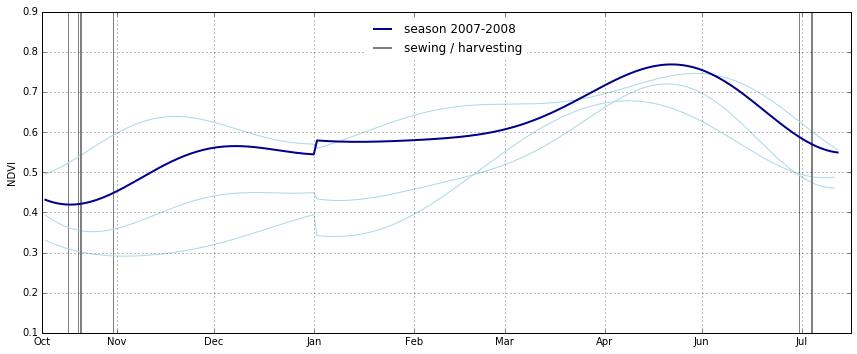

In [59]:
fig,ax = plt.subplots(figsize=(12,5))
ax.axvline(sos0102, color='gray')
ax.axvline(sos0708, color='gray')
ax.axvline(sos1011, color='gray')
ax.axvline(sos1112, color='gray')
ax.axvline(eos0102, color='gray')
ax.axvline(eos0708, color='gray')
ax.axvline(eos1011, color='gray')
ax.axvline(eos1112, color='gray')

ax.plot((s0102.index + offsets.DateOffset(84)).dayofyear, s0102.values/10000., 
         color='lightblue', label='01-02')
plot1011, = ax.plot((s0708.index + offsets.DateOffset(84)).dayofyear, s0708.values/10000., 
         color='darkblue', label='07-08', lw=2, zorder=40)
ax.plot((s1011.index + offsets.DateOffset(84)).dayofyear, s1011.values/10000., 
                   color='lightblue', label='10-11')
ax.plot((s1112.index + offsets.DateOffset(84)).dayofyear, s1112.values/10000., 
         color='lightblue', label='11-12')
#plt.legend()

ax.set_xticks(np.array([  0,  23,  53,  84, 115, 143, 174, 204, 235]))
ax.set_xticklabels(['Oct','Nov','Dec','Jan','Feb','Mar','Apr','Jun','Jul'])
ax.set_ylabel('NDVI')

ax.set_ylim(0.1,0.9)
plt_sos1011 = ax.axvline(sos0708, color='gray',lw=2)
plt_eos1011 = ax.axvline(eos0708, color='gray',lw=2)
plt.grid()
plt.tight_layout()
leg = plt.legend([plot1011,plt_sos1011],['season 2007-2008',
                                                    'sewing / harvesting'], loc=9)
leg.get_frame().set_linewidth(0.0)
plt.savefig(r'D:\Data\NDAI_VHI_GROUNDTRUTH\png//seasons_sel_yongqiao_RECON_NDVI_v1.png',dpi=600)
plt.show()